### Import libraries

In [2]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt

### File and Prediction point

In [3]:
# path to zip file
zipfile_ou = '../data/anonymisedData.zip'

# prediction point - days from start of course
prediction_point = None

### Load Data
- registrations
- courses
- students
- student_vle
- vle
- student_assessments
- assessments

In [4]:
# load files

def load_data(zip_file_path):
    '''Loads the data from the Open University Learning Analytics dataset zip file.'''
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        registrations = pd.read_csv(zip_file.open('studentRegistration.csv'))
        courses = pd.read_csv(zip_file.open('courses.csv'))
        students = pd.read_csv(zip_file.open('studentInfo.csv'))
        student_vle = pd.read_csv(zip_file.open('studentVle.csv'))
        vle = pd.read_csv(zip_file.open('vle.csv'))
        student_assessments = pd.read_csv(zip_file.open('studentAssessment.csv'))
        assessments = pd.read_csv(zip_file.open('assessments.csv'))
    
    return registrations, courses, students, student_vle, vle, student_assessments, assessments

In [5]:
registrations, courses, students, student_vle, vle, student_assessments, assessments = load_data(zipfile_ou)

## Clean and Add Student Biographical and Registration Information


In [6]:

# merge students and courses
student_regist = pd.merge(students, courses, on=['code_module', 'code_presentation'], validate='many_to_one')

# merge registrations
student_regist = pd.merge(student_regist, registrations, on=['code_module', 'code_presentation', 'id_student'], how = 'left', validate='1:1')


there are 3538 students with multiple registrations

In [8]:
registration_count = student_regist.groupby(['id_student']).size().reset_index(name='registration_count')

# Filter the results to include only students with more than one registration
students_with_multiple_registrations = registration_count[registration_count['registration_count'] > 1]

# Print the results
print(students_with_multiple_registrations)

       id_student  registration_count
2            8462                   2
9           24213                   2
16          25629                   2
29          27417                   2
34          27891                   2
...           ...                 ...
28741     2691780                   3
28743     2692101                   2
28772     2697921                   3
28777     2698535                   2
28783     2710343                   2

[3538 rows x 2 columns]


In [10]:

#prediction_point default
#if prediction_point is None:
#    prediction_point = max(student_regist['module_presentation_length'])


In [11]:

# drop missing value rows (date_registration, imd_band)
student_regist.dropna(subset=['date_registration', 'imd_band'], inplace=True)


In [12]:

# prediction point must be less than course length, integer, and greater than 0
if prediction_point is not None:
    assert isinstance(prediction_point, int) and prediction_point > 0 and prediction_point <= (max(student_regist['module_presentation_length']) + 7), "Error: Invalid prediction point.\n\nPlease provide an integer value greater than 0 and less than or equal to the maximum course length.\n\nThis is the number of days from the start of the course for which you want to predict the outcome."
    
    # withdrawn or failed before prediction point - remove
    withdrawn_fail_condition = (student_regist['final_result'].isin(['Withdrawn', 'Fail'])) & (student_regist['date_unregistration'] <= prediction_point)
    student_regist.loc[withdrawn_fail_condition, 'status'] = 'remove_outcome_known'
    
    # unregister after prediction point - keep
    unregister_after_condition = student_regist['date_unregistration'] > prediction_point
    student_regist.loc[unregister_after_condition, 'status'] = 'keep'
    
    # if no unregistration date - keep
    no_unregistration_condition = student_regist['date_unregistration'].isna()
    student_regist.loc[no_unregistration_condition, 'status'] = 'keep'
    
    # query case
    student_regist.loc[~(withdrawn_fail_condition | unregister_after_condition | no_unregistration_condition), 'status'] = 'query'


# rows which need investigation
query_rows = student_regist[student_regist['status'] == 'query'] | student_regist[student_regist['status'].isna()]


In [13]:
query_rows.info()
not query_rows.empty

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   code_module                 0 non-null      bool 
 1   code_presentation           0 non-null      bool 
 2   id_student                  0 non-null      int64
 3   gender                      0 non-null      bool 
 4   region                      0 non-null      bool 
 5   highest_education           0 non-null      bool 
 6   imd_band                    0 non-null      bool 
 7   age_band                    0 non-null      bool 
 8   num_of_prev_attempts        0 non-null      int64
 9   studied_credits             0 non-null      int64
 10  disability                  0 non-null      bool 
 11  final_result                0 non-null      bool 
 12  module_presentation_length  0 non-null      int64
 13  date_registration           0 non-null      bool 
 14  date_unregistration   

False

In [14]:

# print rows which need investigation
if not query_rows.empty:
    print("The following rows need investigation.  They are excluded from the following analysis: \n")
    print(query_rows)
    student_regist = student_regist[~student_regist.isin(query_rows)].dropna()


In [15]:
student_regist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31437 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 31437 non-null  object 
 1   code_presentation           31437 non-null  object 
 2   id_student                  31437 non-null  int64  
 3   gender                      31437 non-null  object 
 4   region                      31437 non-null  object 
 5   highest_education           31437 non-null  object 
 6   imd_band                    31437 non-null  object 
 7   age_band                    31437 non-null  object 
 8   num_of_prev_attempts        31437 non-null  int64  
 9   studied_credits             31437 non-null  int64  
 10  disability                  31437 non-null  object 
 11  final_result                31437 non-null  object 
 12  module_presentation_length  31437 non-null  int64  
 13  date_registration           314

In [16]:

# replace missing date_unreg with module_presentation_length
student_regist['date_unregistration'] = student_regist['date_unregistration'].fillna(student_regist['module_presentation_length'])


In [17]:



# drop students who unregistered before starting
student_regist = student_regist[student_regist['date_unregistration'] >= student_regist['date_registration']]



In [18]:

# remove rows from final student df which are not needed
model_final = student_regist[student_regist['status'] != 'remove_outcome_known']
   





In [19]:
model_final.count()
#model_final['status'].unique()

code_module                   21640
code_presentation             21640
id_student                    21640
gender                        21640
region                        21640
highest_education             21640
imd_band                      21640
age_band                      21640
num_of_prev_attempts          21640
studied_credits               21640
disability                    21640
final_result                  21640
module_presentation_length    21640
date_registration             21640
date_unregistration           21640
status                        21640
dtype: int64

## Clean and Add Assessment Information

In [43]:
# merge 'assessments' and 'courses' on 'code_module' and 'code_presentation'
course_assess = pd.merge(assessments, courses, on=['code_module', 'code_presentation'], how='left')

In [44]:
# missing assessment dates
missing_assess = course_assess.isnull().sum()
print("Missing values in course_assess: \n\n{}".format(missing_assess))

Missing values in course_assess: 

code_module                    0
code_presentation              0
id_assessment                  0
assessment_type                0
date                          11
weight                         0
module_presentation_length     0
dtype: int64


In [45]:
# fill in the missing 'date' values with course final week (as per literature)
value_to_fill = course_assess['module_presentation_length'] - 3
course_assess['date'] = course_assess['date'].fillna(value_to_fill)


In [46]:

# merge student_assessments with course_assess
stu_assess = pd.merge(student_assessments, course_assess, on=['id_assessment'], how='left')


In [47]:
missing_score = stu_assess.isnull().sum()
print("Missing values in course_assess: \n\n{}".format(missing_score))

Missing values in course_assess: 

id_assessment                   0
id_student                      0
date_submitted                  0
is_banked                       0
score                         173
code_module                     0
code_presentation               0
assessment_type                 0
date                            0
weight                          0
module_presentation_length      0
dtype: int64


173 rows with missing scores
160 students with missing scores

assessment and student rows removed

It is not prudent to impute a score where they are missing.  

In [48]:

# students who have no score for an assessment
missing_score_rows = stu_assess[stu_assess['score'].isna()]
print(missing_score_rows['id_student'].nunique())


160


In [49]:

if not missing_score_rows.empty:
    print("The following students have missing 'scores'. They are excluded from the following analysis: \n")
    print(missing_score_rows)

    # student ids with missing score
    unique_ids_missing = missing_score_rows['id_student'].unique()

    # remove students with missing score from model_final
    model_final = model_final[~model_final['id_student'].isin(unique_ids_missing)]

    # drop rows with missing score
    stu_assess.dropna(subset=['score'], inplace=True)


The following students have missing 'scores'. They are excluded from the following analysis: 

        id_assessment  id_student  date_submitted  is_banked  score  \
215              1752      721259              22          0    NaN   
937              1754      260355             127          0    NaN   
2364             1760     2606802             180          0    NaN   
3358            14984      186780              77          0    NaN   
3914            14984      531205              26          0    NaN   
...               ...         ...             ...        ...    ...   
148929          34903      582670             241          0    NaN   
159251          37415      610738              87          0    NaN   
166390          37427      631786             221          0    NaN   
169725          37435      648110              62          0    NaN   
170103          37435      480914              49          0    NaN   

       code_module code_presentation assessment_type

Date Range: 12.0 to 266.0


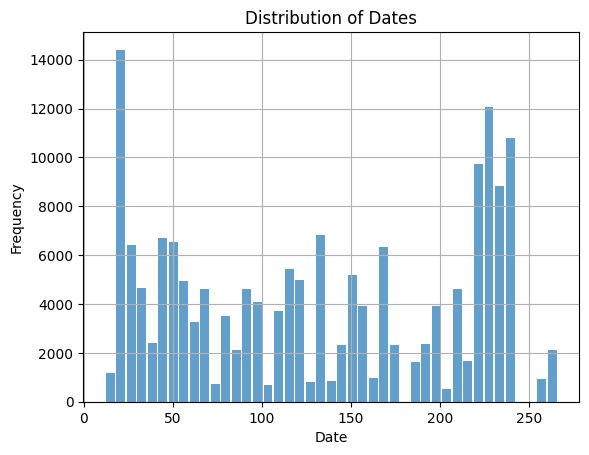

In [50]:
# assessment date range check
date_values = stu_assess['date']
print('Date Range:', date_values.min(), 'to', date_values.max())


# plotting the distribution
plt.hist(date_values, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.grid(True)
plt.show()

Above are the submission dates - all within course dates (start and finish).
Student submissions should be similar but with leeway either side of the due date.
However, submitting before the course starts and well after the course finishes is not possible.  

As can be seen - there are outliers (negative days - before course started) and signficantly after it finished. 

Date Range: -11 to 608


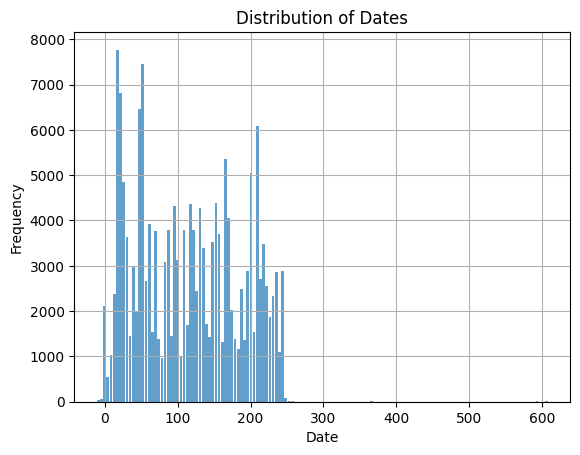

In [51]:
# assessment date range check
stu_date_values = stu_assess['date_submitted']
print('Date Range:', stu_date_values.min(), 'to', stu_date_values.max())


# plotting the distribution
plt.hist(stu_date_values, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.grid(True)
plt.show()

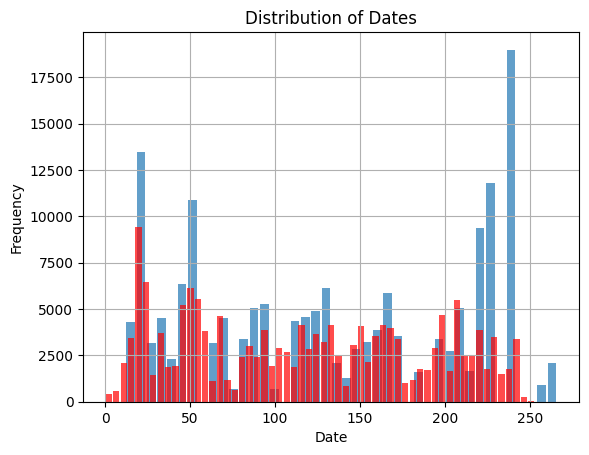

In [56]:
# plotting the distribution
plt.hist(stu_assess['date'], bins='auto', alpha=0.7, rwidth=0.85)
plt.hist(stu_assess['date_submitted'], bins='auto', alpha=0.7, rwidth=0.85, color='red')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.grid(True)
plt.show()

In [52]:

greater_than_max_length = stu_assess[stu_assess['date_submitted'] > stu_assess['module_presentation_length']]
greater_than_max_length.groupby(['code_module', 'code_presentation']).count()['id_student']



code_module  code_presentation
CCC          2014B                 3
             2014J                 1
DDD          2013B                 4
             2014B                 3
             2014J                 1
FFF          2013B                25
             2013J                26
             2014B                17
             2014J                 2
Name: id_student, dtype: int64

It seems like module FFF has a different assessment structure - allowing for submissions well after module ended.

In [57]:

# remove students with negative or extreme date_submitted values
max_module_length = stu_assess['module_presentation_length'].max() + 10
greater_than_max_length = stu_assess[stu_assess['date_submitted'] > max_module_length]['id_student'].unique()
less_than_zero = stu_assess[stu_assess['date_submitted'] < 0]['id_student'].unique()
students_to_remove = set(greater_than_max_length) | set(less_than_zero)
model_final = model_final[~model_final['id_student'].isin(students_to_remove)]
stu_assess = stu_assess[~stu_assess['id_student'].isin(students_to_remove)]



In [54]:
# if prediction_point is None
if prediction_point is None:
    # no data reduction
    model_student_assess = stu_assess
    model_course_assess = course_assess
else:
    # prediction point must be less than course length, integer, and greater than 0
    assert isinstance(prediction_point, int) and prediction_point > 0 and prediction_point <= (max(courses['module_presentation_length'])+7), "Error: Invalid prediction point.\n\nPlease provide an integer value greater than 0 and less than or equal to the maximum course length.\n\nThis is the number of days from the start of the course for which you want to predict the outcome."

    # reduce data by prediction point
    model_student_assess = stu_assess[stu_assess['date'] <= prediction_point]
    model_course_assess = course_assess[course_assess['date'] <= prediction_point]


In [55]:

# get expected assessment details

expected_ass = model_course_assess.groupby(['code_module', 'code_presentation'])['id_assessment'].count().reset_index()
expected_ass = expected_ass.rename(columns={'id_assessment': 'exp_sub_count'})
date_sum = model_course_assess.groupby(['code_module', 'code_presentation'])['date'].sum().reset_index()
expected_ass = expected_ass.merge(date_sum, on=['code_module', 'code_presentation'], how='left')
expected_ass = expected_ass.rename(columns={'date': 'exp_sub_date_sum'})


In [ ]:

# summarise students' assessments by module_presentation
student_assessment_summary = model_student_assess.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    count_id_assessment=('id_assessment', 'count'),
    sum_score=('score', 'sum'),
    sum_date=('date', 'sum')
    ).reset_index()


In [ ]:

# merge student_assessment_summary and expected_ass on code_module and code_presentation
merged_assess_summary = student_assessment_summary.merge(expected_ass, on=['code_module', 'code_presentation'])


In [ ]:

# calculate the new features
merged_assess_summary['prop_submissions'] = merged_assess_summary['count_id_assessment'] / merged_assess_summary['exp_sub_count']
merged_assess_summary['avg_score'] = merged_assess_summary['sum_score'] / merged_assess_summary['exp_sub_count']
merged_assess_summary['submission_distance'] = merged_assess_summary['exp_sub_date_sum'] - merged_assess_summary['sum_date']


In [ ]:

# merge with 'model_final'
model_final = model_final.merge(merged_assess_summary, on=['id_student', 'code_module', 'code_presentation'], how='inner')



In [58]:
model_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21020 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 21020 non-null  object 
 1   code_presentation           21020 non-null  object 
 2   id_student                  21020 non-null  int64  
 3   gender                      21020 non-null  object 
 4   region                      21020 non-null  object 
 5   highest_education           21020 non-null  object 
 6   imd_band                    21020 non-null  object 
 7   age_band                    21020 non-null  object 
 8   num_of_prev_attempts        21020 non-null  int64  
 9   studied_credits             21020 non-null  int64  
 10  disability                  21020 non-null  object 
 11  final_result                21020 non-null  object 
 12  module_presentation_length  21020 non-null  int64  
 13  date_registration           210

## Clean and add VLE information
- merge 'vle' and 'courses' and 'student_vle'
- remove columns (week_from, week_to)
- filter the rows where 'date' <= 'prediction_point'
- create new features: 
  - vle_activity_count
  - student vle type count
  - student total clicks
  - student days active (engaged)

In [ ]:

# merge 'vle' and 'courses' on 'code_module' and 'code_presentation'
course_vle = vle.merge(courses, on=['code_module', 'code_presentation'], how='left').drop(['week_from', 'week_to'], axis=1)


In [ ]:

# merge vle with student_vle
all_stu_vle = pd.merge(student_vle, course_vle, on=['id_site', 'code_module', 'code_presentation'], how='left')


In [ ]:

# if prediction_point is None
if prediction_point is None:
    # no filtering
    all_stu_vle = all_stu_vle
else:
    # prediction point must be less than or equal to the maximum date
    assert isinstance(prediction_point, int) and prediction_point <= max(all_stu_vle['date']), "Error: Invalid prediction point.\n\nPlease provide an integer value less than or equal to the maximum date.\n\nThis is the cutoff date for filtering the rows."

    # filter the rows where 'date' <= 'prediction_point'
    all_stu_vle = all_stu_vle[all_stu_vle['date'] <= prediction_point]


In [ ]:

# filter the rows where 'date' is greater than 'module_presentation_length'
vle_after_done = all_stu_vle[all_stu_vle['date'] > all_stu_vle['module_presentation_length']]


In [ ]:

if not vle_after_done.empty:
    print("The following rows need investigation. They are excluded from the following analysis: \n")
    print(vle_after_done)

    # match rows based on 'code_module', 'code_presentation', and 'id_student'
    matching_rows = model_final[model_final[['code_module', 'code_presentation', 'id_student']].isin(vle_after_done).all(axis=1)]

    # remove the matching rows from 'model_final'
    model_final = model_final[~model_final.index.isin(matching_rows.index)]


In [ ]:

# aggregations for each column
aggregations = {
'id_site': 'count',
'activity_type': 'nunique',
'sum_click': 'sum',
'date': lambda x: x.nunique()
}

# group and apply the aggregations
grouped_stu_vle = all_stu_vle.groupby(['code_module', 'code_presentation', 'id_student']).agg(aggregations).reset_index()

# rename the columns
grouped_stu_vle.rename(columns={
'id_site': 'stu_activity_count',
'activity_type': 'stu_activity_type_count',
'sum_click': 'stu_total_clicks',
'date': 'stu_days_active'
}, inplace=True)

    

In [ ]:
# number of vle types per module_presentation
group_vle = vle.groupby(['code_module', 'code_presentation'])['activity_type'].nunique().reset_index()
group_vle.rename(columns={'activity_type': 'mod_pres_vle_type_count'}, inplace=True)


In [ ]:

# merge 'grouped_stu_vle' and 'group_vle' on 'code_module' and 'code_presentation'
merged_vle_summary = grouped_stu_vle.merge(group_vle, on=['code_module', 'code_presentation'], how='left')


In [ ]:

# merge with 'model_final'
model_final = model_final.merge(merged_vle_summary, on=['id_student', 'code_module', 'code_presentation'], how='inner')



## Tidy model data table

In [ ]:

# new columns for module_presentation - subject, year, month
model_final['year'] = model_final['code_presentation'].str[:4].astype(int)
model_final['month'] = model_final['code_presentation'].str[-1].map({'J': 'Oct', 'B': 'Feb'})

# module subject mapping
code_module_mapping = {
        'AAA': 'SocSci',
        'BBB': 'SocSci',
        'GGG': 'SocSci',
        'CCC': 'Stem',
        'DDD': 'Stem',
        'EEE': 'Stem',
        'FFF': 'Stem'
    }
model_final['subject'] = model_final['code_module'].map(code_module_mapping)

    

In [ ]:
# rename 'module_presentation_length' to 'course_length'
model_final.rename(columns={'module_presentation_length': 'course_length'}, inplace=True)


In [ ]:

# combine 'code_module', 'code_presentation', and 'id_student' into 'mod_pres_stu'
#model_final['mod_pres_stu'] = model_final['code_module'] + '-' + model_final['code_presentation'] + '-' + model_final['id_student'].astype(str)


In [ ]:
#model_final.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,avg_score,submission_distance,stu_activity_count,stu_activity_type_count,stu_total_clicks,stu_days_active,mod_pres_vle_type_count,year,month,subject
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,68.333333,265.0,196,6,934,40,9,2013,Oct,SocSci
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,55.333333,265.0,430,7,1435,80,9,2013,Oct,SocSci
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,63.333333,265.0,663,8,2158,123,9,2013,Oct,SocSci
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,45.333333,265.0,352,7,1034,70,9,2013,Oct,SocSci
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,...,56.666667,265.0,723,8,2445,143,9,2013,Oct,SocSci


In [ ]:

# drop the separate columns 'code_module', 'code_presentation', and 'id_student'
#model_final.drop(columns=['code_presentation' ], inplace=True)


In [ ]:

# move 'final_result' to the last column
final_result_column = model_final.pop('final_result')
model_final['final_result'] = final_result_column


In [ ]:

# insert 'mod_pres_stu' as the first column
#mod_pres_stu_column = model_final.pop('mod_pres_stu')
#model_final.insert(0, 'mod_pres_stu', mod_pres_stu_column)


In [ ]:

# drop columns: 'count_id_assessment', 'sum_score', 'sum_date', 'exp_sub_count', 'exp_sub_date_sum'
model_final.drop(columns=['id_student','count_id_assessment', 'sum_score', 'sum_date', 'exp_sub_count', 'exp_sub_date_sum'], inplace=True)




In [ ]:
model_final.info()
model_final.to_csv('../data/final_model_PP_NONE_20230522.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19689 entries, 0 to 19688
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   code_module              19689 non-null  object 
 1   gender                   19689 non-null  object 
 2   region                   19689 non-null  object 
 3   highest_education        19689 non-null  object 
 4   imd_band                 19689 non-null  object 
 5   age_band                 19689 non-null  object 
 6   num_of_prev_attempts     19689 non-null  int64  
 7   studied_credits          19689 non-null  int64  
 8   disability               19689 non-null  object 
 9   course_length            19689 non-null  int64  
 10  date_registration        19689 non-null  float64
 11  date_unregistration      19689 non-null  float64
 12  status                   19689 non-null  object 
 13  prop_submissions         19689 non-null  float64
 14  avg_score             